In [87]:
# Desired Transformations:

# number of disinct parties (vertical partitioning)
# must be less than or equal to the number of indendent features in the dataset
distinct_parties = 5

# normalize the data
normalize = True

# test/train split
test_train_split = 0.2

# set special values to Nan
set_special_values_to_nan = True

# remove rows with special values (overrides set_special_values_to_nan)
remove_special_values = True

# output directory
output_dir = "pre_processed_adult_5p"

In [88]:
### Libraries for Data Handling
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [89]:
# import, clean and transform the dataset
adult_df = pd.read_csv('./datasets/adult_dataset/adult.data', sep=',', header=None)
adult_column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']
adult_df.columns = adult_column_names

# Remove unkowns from the dataset
if remove_special_values or set_special_values_to_nan:
    adult_df.replace("?", np.nan, inplace=True)
    if remove_special_values:
        adult_df.dropna(inplace=True)

# Transform the income classification column to binary & remove it from the features
labels = adult_df.filter(['income'], axis=1)
labels.replace('<=50K', 0, inplace=True, regex=True)
labels.replace('>50K', 1, inplace=True, regex=True)
adult_df = adult_df.drop('income', axis=1)

# Label encode the catagorial columns
catagorial_columns = adult_df.select_dtypes(include=['object']).columns
for column in catagorial_columns:
    adult_df[column] = adult_df[column].astype('category').cat.codes

# Normalize the data
if normalize:
    sc = StandardScaler()
    adult_ndarray = sc.fit_transform(adult_df)

In [90]:
# partition dataset into n parties
if distinct_parties:
    column_partitions = np.array_split(adult_ndarray, distinct_parties, axis=1)
    column_partition_labels = np.array_split(adult_column_names[:-1], distinct_parties, axis=0)
else:
    column_partitions = [adult_ndarray]
    column_partition_labels = [adult_column_names[:-1]]

In [91]:
# split the dataset into test and training sets
if distinct_parties:
    train_data = []
    test_data = []
    for i, partition in enumerate(column_partitions):
        X_train, X_test, y_train, y_test = train_test_split( \
            partition, labels, test_size=test_train_split, random_state=42, shuffle=False)
        train_data.append((X_train, y_train))
        test_data.append((X_test, y_test))

In [92]:
# export datasets
base_dir = './datasets/' + output_dir + '/'
base_path = Path(base_dir)
base_path.mkdir(parents=True, exist_ok=True)



column_names = list(adult_column_names[:-1])
for i in range(distinct_parties):
    train_data[i] = pd.DataFrame(data=train_data[i][0], columns=list(column_partition_labels[i]))
    test_data[i] = pd.DataFrame(data=test_data[i][0], columns=list(column_partition_labels[i]))

    train_data[i].to_csv(base_dir + f'train_data_party_{i+1}.csv', index=False)
    test_data[i].to_csv(base_dir + f'test_data_party_{i+1}.csv', index=False)

y_train.to_csv(base_dir + 'train_labels.csv', index=False)
y_test.to_csv(base_dir + 'test_labels.csv', index=False)
labels.to_csv(base_dir + 'labels.csv', index=False)


<Axes: xlabel='income'>

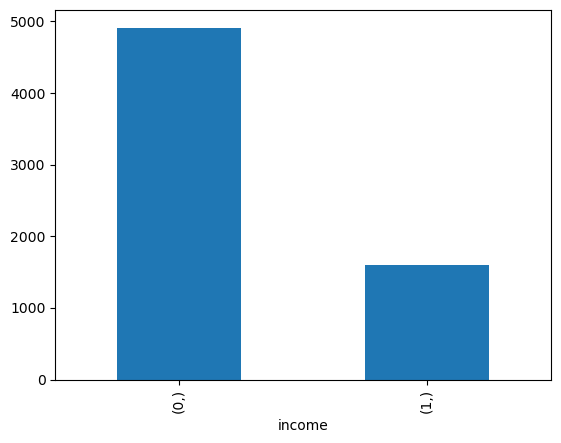

In [93]:
# Identify the distribution of the labels
y_test.value_counts().plot(kind='bar')